In [7]:
import torch
import torch.nn as nn
import torchvision

In [8]:
def double_convolution(in_channel, out_channel):
  conv = nn.Sequential(
      nn.Conv2d(in_channel, out_channel, kernel_size=3,padding=1, bias=False),
      nn.BatchNorm2d(out_channel),
      nn.ReLU(inplace=True),

      nn.Conv2d(out_channel, out_channel, kernel_size=3,padding=1, bias=False),
      nn.BatchNorm2d(out_channel),
      nn.ReLU(inplace=True)
  )
  return conv

In [9]:
def center_crop(tensor, target_tensor):
  target_size = target_tensor.size()[2]
  tensor_size = tensor.size()[2]
  delta = tensor_size - target_size
  if delta % 2 == 0:
    delta = delta // 2
    return tensor[:,:,delta:tensor_size-delta,delta:tensor_size-delta]
  delta = delta // 2
  return tensor[:,:,delta:tensor_size-delta-1,delta:tensor_size-delta-1]

In [10]:
class UpBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(UpBlock, self).__init__()
        self.up_sample = nn.Upsample(scale_factor=2, mode='nearest', align_corners=None)
        self.double_conv = double_convolution(in_channels, out_channels)

    def forward(self, down_input, skip_input):
        x = self.up_sample(down_input)
        x = torch.cat([x, skip_input], dim=1)
        return self.double_conv(x)

In [11]:
class UNet(nn.Module):

    def __init__(self, n_class=6):
        super(UNet,self).__init__()

        # TODO: Define needed layers, use n_class variable in the last layer.
        self.max_pool_2down_mp_1 = nn.MaxPool2d(kernel_size=2)
        self.down_dbl_conv_1 = double_convolution(3,64)
        self.down_dbl_conv_2 = double_convolution(64,128)
        self.down_dbl_conv_3 = double_convolution(128,256)
        self.down_dbl_conv_4 = double_convolution(256,512)
        self.down_dbl_conv_5 = double_convolution(512,1024)

        self.up_dbl_conv_1 = UpBlock(1024+512,512)
        self.up_dbl_conv_2 = UpBlock(512+256,256)
        self.up_dbl_conv_3 = UpBlock(256+128,128)
        self.up_dbl_conv_4 = UpBlock(128+64,64)

        self.final_conv = nn.Conv2d(in_channels=64, out_channels=n_class, kernel_size=1)
    def forward(self, x):
        
        original_dim = x.size()[2]
        while x.size()[2] < 256:
            x = nn.functional.interpolate(x, size=(256, 256), mode='nearest-exact')
        
        # Encoder
        down_1 = self.down_dbl_conv_1(x)
        down_mp_1 = self.max_pool_2x2(down_1)

        down_2 = self.down_dbl_conv_2(down_mp_1)
        down_mp_2 = self.max_pool_2x2(down_2)

        down_3 = self.down_dbl_conv_3(down_mp_2)
        down_mp_3 = self.max_pool_2x2(down_3)

        down_4 = self.down_dbl_conv_4(down_mp_3)
        down_mp_4 = self.max_pool_2x2(down_4)

        down_5 = self.down_dbl_conv_5(down_mp_4)
        
        # Decoder
        up_1 = self.up_dbl_conv_1(down_5,down_4)
     
        up_2 = self.up_dbl_conv_2(up_1,down_3)
       
        up_3 = self.up_dbl_conv_3(up_2,down_2)
   
        up_4 = self.up_dbl_conv_4(up_3,down_1)
   
        out = self.final_conv(up_4)

        out = nn.functional.interpolate(out, size=(original_dim, original_dim), mode='nearest-exact')
        return out

Epoch 0/59
----------
LR 0.0001
train: bce: 0.666218, dice: 0.988072, loss: 0.827145
val: bce: 0.708926, dice: 0.990494, loss: 0.849710
saving best model
0m 23s
Epoch 1/59
----------
LR 0.0001
train: bce: 0.608704, dice: 0.983349, loss: 0.796027
val: bce: 0.694525, dice: 0.990307, loss: 0.842416
saving best model
0m 24s
Epoch 2/59
----------
LR 0.0001
train: bce: 0.580581, dice: 0.981653, loss: 0.781117
val: bce: 0.668541, dice: 0.989859, loss: 0.829200
saving best model
0m 24s
Epoch 3/59
----------
LR 0.0001
train: bce: 0.563241, dice: 0.980893, loss: 0.772067
val: bce: 0.632989, dice: 0.988962, loss: 0.810976
saving best model
0m 24s
Epoch 4/59
----------
LR 0.0001
train: bce: 0.550934, dice: 0.980472, loss: 0.765703
val: bce: 0.600452, dice: 0.987318, loss: 0.793885
saving best model
0m 25s
Epoch 5/59
----------
LR 0.0001
train: bce: 0.540610, dice: 0.980388, loss: 0.760499
val: bce: 0.579008, dice: 0.985133, loss: 0.782070
saving best model
0m 25s
Epoch 6/59
----------
LR 0.0001
tr

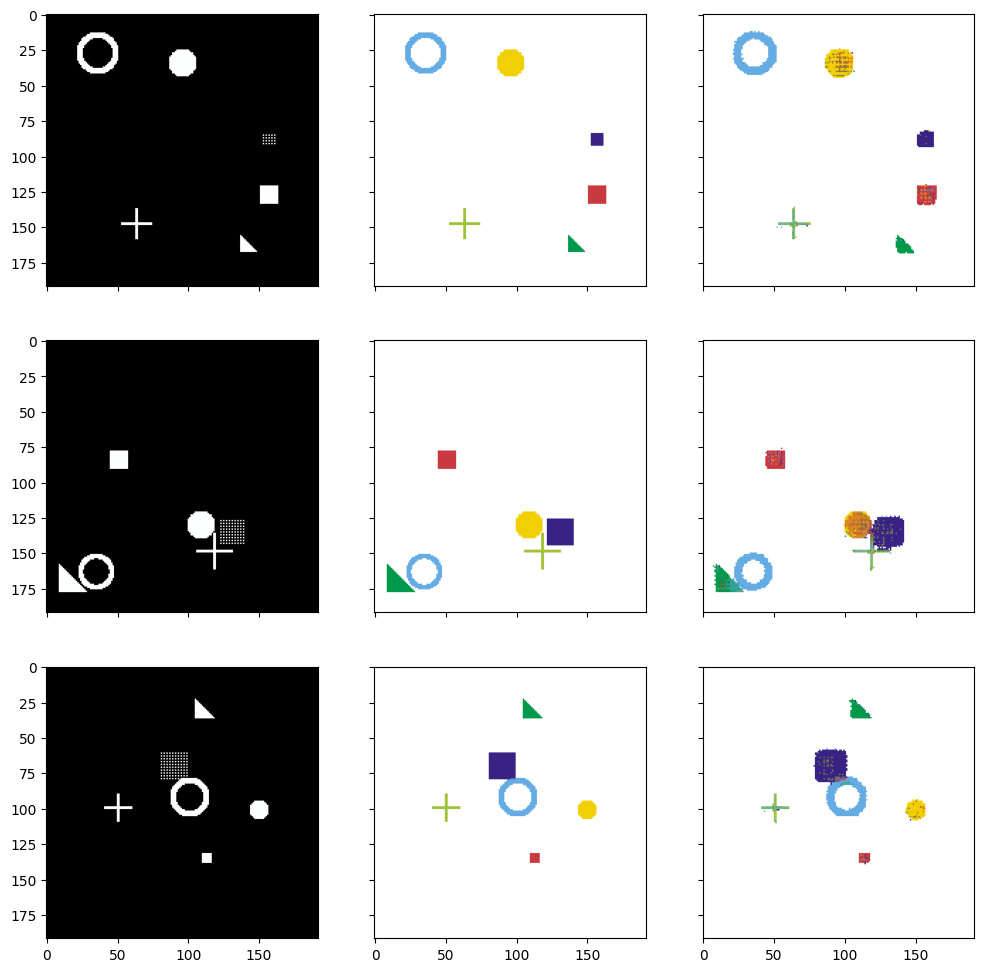

In [12]:
import utility as utils

utils.run(UNet)